**Lab 6: IIR Filtering**


The objective for this lab is to help you understand the relationship between the location
of poles and zeros in the z-domain, the impulse response h[n] in the n-domain, and the frequency
response $H(e^{j\omega})$. We use the system function,
represented as a ratio of polynomials in $z^{-1}$, which can be expressed in either factored or expanded form as:

$$
H(z) = G\frac{\prod_{k=1}^M (1-z_kz^{-1}) }{\prod_{k=1}^N (1-p_kz^{-1})} = \frac{ \sum_{k=0}^M b_kz^{-k}}{ 1- \sum_{k=1}^N a_kz^{-k} }
$$

In [1]:
import numpy as np
import IPython.display as ipd
from scipy import signal
import matplotlib.pyplot as plt

from util import load_audio, plot_signals, plot_spectrogram, plot_frequency_response

from IPython.display import Audio


**1. IIR filters to extract the envelope**

In the previous labs, you extracted the envelope from your reference signal by applying the following system:

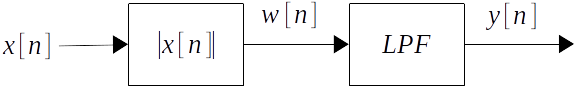

where $w[n] = |x[n]|$ and $y[n]$ was the output of a low-pass FIR filter (averaging filter). In this exercise, you will re-implement this low-pass filter as an IIR.

1.1 First, copy the functions envelope and synthesize from previous work and obtain the same synthesis. 



In [2]:
def synthesize(f0, phi, Ak, t, A):
    y = np.zeros_like(t, dtype=float)
    for k in range(len(Ak)):
        y += Ak[k] * np.cos(2*np.pi*f0*k*t + k*phi - (k-1)*np.pi/2)
    y = A * y / (np.max(np.abs(y)) + 1e-12)
    return y

def envelope(x, N):
    N = int(max(1, N))
    w = np.abs(x).astype(float)
    b = np.ones(N, dtype=float) / N
    y = np.convolve(w, b, mode='same')
    return y

1.2 Let's take a look at the following system:

$$
H(z) = G\frac{1+z^{-1}}{1-rz^{-1}} \quad   0<r<1 \quad, G = \frac{1-r}{2}
$$

Note that the coefficients of the filter are the following:

$$
b_0 = 1, \quad b_1 = 1, \quad a_0 = 1, \quad a_1 = -r, \quad
$$

i. Find the zeros and poles of the system analytically.

Zero(s): numerator 1 + z^-1 = 0 -> z^-1 = -1 -> z = -1
So there is one zero at z = -1

Pole(s): denominator 1 - rz^-1 = 0 -> z^-1 = 1/r -> z = r
So there is one pole at z = r (inside the unit circle because 0 < r < 1 and the system is stable)

We can check this with np.roots: we set b = np.array([1, 1]) for the numerator coefficients and a = np.array([1, -r]) for the denominator. Using a value like r = 0.9, the code returns Zeros: [-1.] and Poles: [0.9], which matches exactly the analytical result.

ii. Use the function `np.roots` to find the zeros and poles using Python. Compare the results with part i.

In [3]:
# We choose some r in (0,1), for example:
r = 0.9

# Coefficients of numerator and denominator
b = np.array([1, 1])      # b0, b1
a = np.array([1, -r])     # a0, a1

# Zeros and poles from the polynomials
zeros = np.roots(b)
poles = np.roots(a)

print("Zeros:", zeros)
print("Poles:", poles)


Zeros: [-1.]
Poles: [0.9]


iii. Use the function  `plot_zeros_poles(z, p)` to plot the zeros and poles found in ii.

In [4]:
from util import plot_zeros_poles

# We plot the zeros and poles
plot_zeros_poles(zeros, poles)


1.3 Let's see the frequency response of this filter:



In [5]:
# Coefficients of the filter
b = np.array([1, 1])   # numerator coefficients: b0, b1
a = np.array([1, -r])  # denominator coefficients: a0, a1

# We plot the frequency response
plot_frequency_response(b, a)

1.4. Change the parameter $r$ in the range $(0, 1)$. What happens when $r$ is increased?

When r increases toward 1, the pole of the filter moves closer to the unit circle. As a result, The magnitude response becomes sharper, with a narrower peak around low frequencies. Also, the filter becomes more selective: low frequencies are passed with higher gain, high frequencies become more attenuate and The system's impulse response lasts longer (because the pole is near the unit circle, which results in a slower decay).

1.5 What type of filter is (low-pass, band-pass, or high-pass filter)?


The combination of this filter produces high attenuation around high frequencies (because the zero at –1 kills ω = π) and high gain around low frequencies (because the pole boosts low frequencies), therefore this is a low-pass filter.

1.6 Now we can use this IIR filter to extract the envelope. Let's define a new function `envelope_iir(x)` that applies the filter to the absolute value of the signal. Note that we are using signal.lfilter function to apply the filter.


In [11]:
def envelope_iir(x, r=0.995):
    w = np.abs(x)
    G = (1 - r) / 2.0          # scaling factor
    b = G * np.array([1, 1])   # [G, G]
    a = np.array([1, -r])
    y = signal.lfilter(b, a, w)
    return y



Extract the envelope of your reference signal using both the FIR and IIR filters and compare the results plot them along with the signal. Change the value of $r$ until you are comfortable with the result.

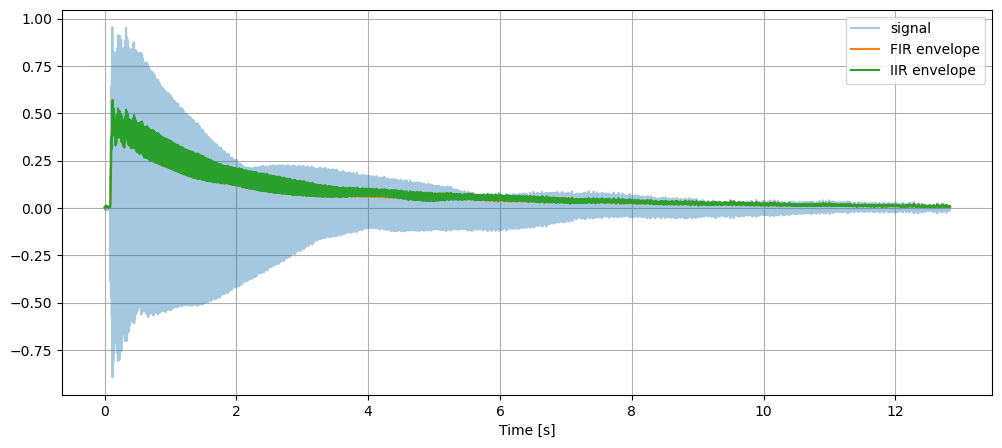

In [12]:
# We load our original audio
x, fs = load_audio("pluck.wav")

# FIR envelope (from previous lab)
env_fir = envelope(x, N=400)     # or whatever N you used before

# IIR envelope (new)
env_iir = envelope_iir(x, r=0.995)   # try 0.98, 0.99, 0.995, 0.997, etc.

t = np.arange(len(x)) / fs

plt.figure(figsize=(12,5))
plt.plot(t, x, label='signal', alpha=0.4)
plt.plot(t, env_fir, label='FIR envelope')
plt.plot(t, env_iir, label='IIR envelope')
plt.xlabel('Time [s]')
plt.legend()
plt.grid(True)
plt.show()


1.7 What are the main differences between the two filters? For instance, compare the number of coefficients.

The main difference between the two envelope filters is that the FIR filter is a moving average, so it needs many coefficients (one for each sample in the window, e.g. N = 400). This makes it very smooth and quite “slow”: it reacts more slowly to changes and has more delay, but its behaviour is very simple and always stable. The IIR filter, instead, is recursive and uses very few coefficients (here basically one zero and one pole, so 2 coefficients). With so few parameters it can create a strong exponential smoothing, so it follows the envelope with much less memory and is computationally cheaper. However, because it is recursive, its shape depends a lot on the pole position r: if r is close to 1 the envelope decays slowly and keeps more past information; if r is smaller the envelope decays faster. 

1.8 Apply the new envelope (extracted from the IIR filter) to the synthesis generated with the `synthesize` function and listen to the result.

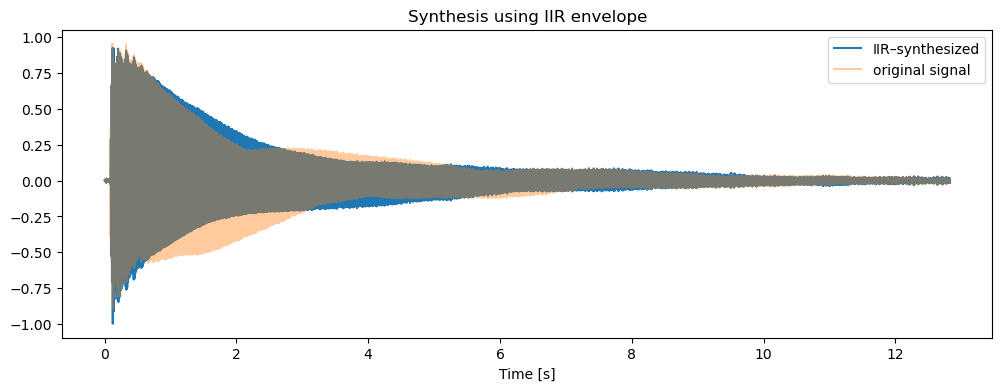

In [13]:
# We copy the parameters from the previous lab
weights = [1, 0.05361973, 0.02075456, 0.00638063, 0.005605868, 0.00289555, 0.001859109, 0.001014176, 0.001188837]
Ak  = [0.0] + weights                    # Ak[1] = harmonic 1
f0  = 82                                 # Hz
phi = 49*np.pi/72                        # phase
A   = np.max(np.abs(x))                  # match peak level

# We normalize the envelope
env_iir = env_iir / (np.max(env_iir) + 1e-12)

# We synthesize the signal again using the new IIR envelope
y_iir = synthesize(f0, phi, Ak, t, env_iir)

# We listen to the result
Audio(y_iir, rate=fs)

# We also plot it to visually compare with the signal
plt.figure(figsize=(12,4))
plt.plot(t, y_iir, label='IIR–synthesized')
plt.plot(t, x, alpha=0.4, label='original signal')
plt.title("Synthesis using IIR envelope")
plt.xlabel("Time [s]")
plt.legend()
plt.show()


---

**2. Band-pass filters**

Now let's work with the following system: 

$$
H(z) = \frac{(1-z^{-1})(1+z^{-1})}{(1-re^{j\omega_n}z^{-1})(1-re^{-j\omega_n}z^{-1})}, \quad 0<r<1
$$

Note that the poles are $p_1 = re^{j\omega_n}$ and $p_2 = re^{-j\omega_n}$; and the zeros are $z_1=1$ and $z_2=-1$. 

2.1 Use the function `plot_zeros_poles` to plot the zeros and poles of the system.

Note: use $w_n = \pi/4$ and $r=0.99$.

In [14]:
# Parameters given in the statement
wn = np.pi / 4      # center (normalized) frequency
r  = 0.99           # pole radius

# Zeros of the system: z1 = 1, z2 = -1
zeros = np.array([1, -1], dtype=complex)

# Poles of the system: p1 = r·e^{j*wn}, p2 = r·e^{-j*wn}
poles = r * np.exp(1j * np.array([wn, -wn]))

# We plot the zeros and the poles on the z-plane
plot_zeros_poles(zeros, poles)


2.2 Show analytically that $a_k = [1, -2rcos(\omega_n), r^2]$ and $b_k=[1, 0, -1]$.

We start from the system

H(z) = (1 − z⁻¹)(1 + z⁻¹) / [(1 − r·e^{j·ωₙ}·z⁻¹)(1 − r·e^{-j·ωₙ}·z⁻¹)], with 0 < r < 1.

Numerator:
(1 − z⁻¹)(1 + z⁻¹) = 1 + z⁻¹ − z⁻¹ − z⁻² = 1 − z⁻².
This corresponds to the polynomial: 1 + 0·z⁻¹ − 1·z⁻².
So the numerator coefficients are:
b₀ = 1, b₁ = 0, b₂ = −1 → bₖ = [1, 0, −1].

Denominator:
(1 − r·e^{j·ωₙ}·z⁻¹)(1 − r·e^{-j·ωₙ}·z⁻¹)
= 1 − r(e^{j·ωₙ} + e^{-j·ωₙ})·z⁻¹ + r²·e^{j·ωₙ}e^{-j·ωₙ}·z⁻².

Using the identities:
e^{j·ωₙ}e^{-j·ωₙ} = 1
e^{j·ωₙ} + e^{-j·ωₙ} = 2·cos(ωₙ)

we get:
denominator = 1 − 2·r·cos(ωₙ)·z⁻¹ + r²·z⁻².

This corresponds to the polynomial: 1 + a₁·z⁻¹ + a₂·z⁻², so:
a₀ = 1, a₁ = −2·r·cos(ωₙ), a₂ = r² → aₖ = [1, −2·r·cos(ωₙ), r²].

Final result:
We have analytically shown that

aₖ = [1, −2·r·cos(ωₙ), r²] and bₖ = [1, 0, −1].

2.3 Plot the frequency response of the filter. Confirm this is a band-pass filter. What's the central frequency of the passband?

In [15]:
# Parameters of the band-pass filter
r = 0.99
wn = np.pi / 4   # given ω_n

# Coefficients from 2.2: b_k = [1, 0, -1], a_k = [1, -2 r cos(ω_n), r^2]
b = np.array([1.0, 0.0, -1.0])
a = np.array([1.0, -2 * r * np.cos(wn), r**2])

# Plot the frequency response |H(e^jω)| and its phase
plot_frequency_response(b, a)


From the magnitude plot we see that low frequencies and very high frequencies are strongly attenuated, while there is a clear peak around a single frequency, so the system behaves as a band-pass filter. The peak is at the angle of the poles, which is ωn. Here ωn = π/4, so the central frequency of the passband is ω0 = π/4 rad/sample, i.e. a normalized frequency of ω0/(2π) = 1/8 of the sampling frequency.

2.4 Define a function `bpf(x, f, r, fs)` that applies the above band-pass filter. 

Note 1: remember that a frequency can be converted to the normalized radian frequncy by: $\omega_n = 2\pi f_n/f_s$.

Note 2: use `signal.lfilter` function to implement the filter.

In [16]:
def bpf(x, fn, fs, r=0.995):
    """
    Applies the band-pass filter with central frequency fn.

    Parameters
    ----------
    x : np.array
        Input signal.
    fn : float
        Central frequency of the band-pass in Hz.
    fs : float
        Sampling frequency in Hz.
    r : float
        Pole radius (0 < r < 1).

    Returns
    -------
    y : np.array
        Output of the band-pass filter.
    """
    # Normalized radian frequency ωn = 2π fn / fs
    wn = 2 * np.pi * fn / fs

    # Filter coefficients from H(z):
    # numerator  b_k = [1, 0, -1]
    b = np.array([1.0, 0.0, -1.0])

    # denominator a_k = [1, -2 r cos(ωn), r^2]
    a = np.array([1.0, -2 * r * np.cos(wn), r**2])

    # Apply the IIR band-pass filter
    y = signal.lfilter(b, a, x)

    return y


2.5 Regardless of the phase, until now we were synthesizing the instrument signal by summing $K$ harmonics of the signal with different weights ($A_k$) and multiplying the sum by the envelope of the reference signal ($e(t)$):

$$y(t) = e(t) \cdot \sum_{k=1}^K A_k\cos\left(2\pi kf_0 t \right), $$

where $f_0$ is the fundamental frequency of the note. Now we want to improve this synthesis by finding a time-dependent amplitude ($A_k(t)$) for each harmonic:

$$y(t) = \sum_{k=1}^K A_k(t) \cos\left(2\pi kf_0 t \right), $$

where $A_k(t)$ is the amplitude of the harmonic $k$. To extract the amplitudes $A_k(t)$ we'll apply a band-pass filter with central frequency $kf_0$ and calculate the envelope of the output by using the `envelope_iir`.


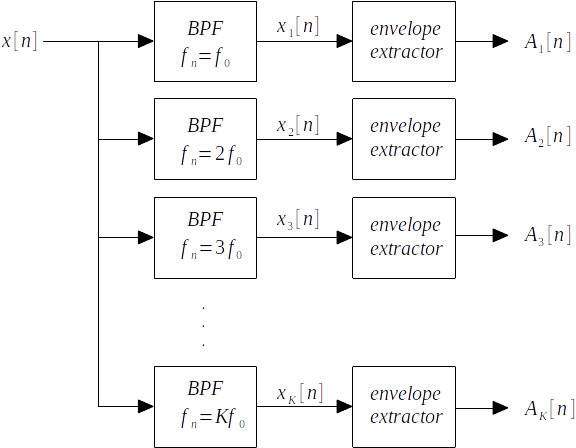

For instance, the following code should extract the envelope of the fundamental frequency component. Change the value of $f_0$ to coincide with your fundamental frequency and check the result. 

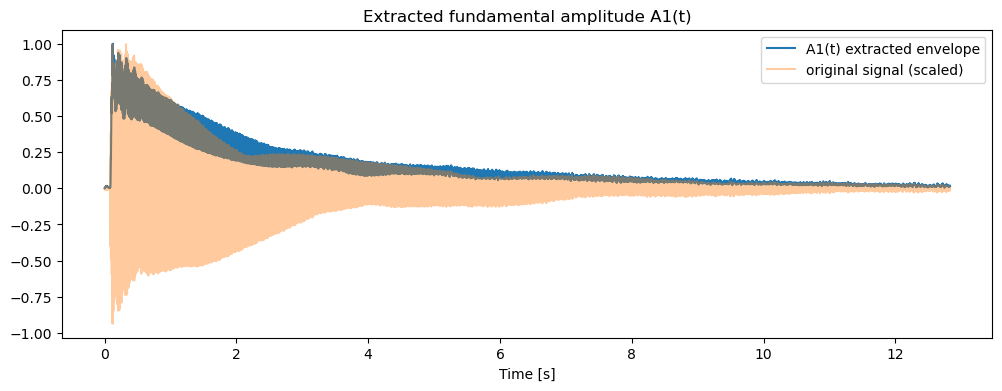

In [17]:
# Fundamental frequency (we adjust it to match our signal)
f0 = 82

# We apply the band-pass filter around f0
x1 = bpf(x, fn=f0, fs=fs, r=0.99)

# We extract its envelope using the IIR envelope extractor
A1 = envelope_iir(x1, r=0.995)

# We normalize so plotting is easier
A1 = A1 / (np.max(A1) + 1e-12)

# We plot the result
plt.figure(figsize=(12,4))
plt.plot(t, A1, label='A1(t) extracted envelope')
plt.plot(t, x / np.max(np.abs(x)), alpha=0.4, label='original signal (scaled)')
plt.title("Extracted fundamental amplitude A1(t)")
plt.xlabel("Time [s]")
plt.legend()
plt.show()


2.6 Complete the `synthetize_with_bpf` function to implement a synthesis applying different envelopes for each harmonic.


In [18]:
def synthetize_with_bpf(x, f0, phi, K, fs):
    """
    Synthesizes a harmonic signal using different envelopes for each harmonic.
    The envelopes are extracted from the reference signal x.
    """

    # Time axis
    N = len(x)
    t = np.arange(N) / fs

    # Output signal
    y = np.zeros(N, dtype=float)

    # Loop over harmonics k = 1, 2, ..., K
    for k in range(1, K + 1):
        fk = k * f0                      # central frequency of this harmonic

        # Band-pass filter around fk to isolate harmonic k
        xk = bpf(x, fk, fs=fs)           # uses the bpf() we defined in 2.4

        # We extract its envelope A_k(t) with the IIR envelope extractor
        Ak_t = envelope_iir(xk)          # uses the envelope_iir() from 1.6

        # We add harmonic k with its own time-varying amplitude
        y += Ak_t * np.cos(2 * np.pi * fk * t + k * phi)

    # Simple normalization to avoid clipping
    y = y / (np.max(np.abs(y)) + 1e-12)

    return y


2.6 Call the function `synthetize_with_bpf` to get the synthesized signal and **listen to it**.

Note that now you can increase the number of harmonics $K$ as you want because we are not manually measuring the weights of each harmonic.

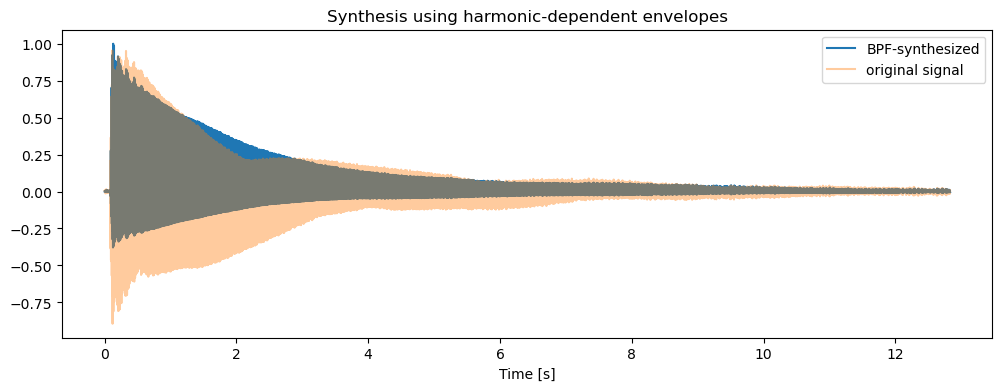

In [19]:
# Number of harmonics you want to include
K = 20   # we could increase this number freely

# We generate the new synthesis using harmonic envelopes
y_bpf = synthetize_with_bpf(x, f0, phi, K, fs)

# We listen to the synthesized result
Audio(y_bpf, rate=fs)

# We also plot it to visually compare with the original signal
plt.figure(figsize=(12,4))
plt.plot(t, y_bpf, label="BPF-synthesized")
plt.plot(t, x, alpha=0.4, label="original signal")
plt.title("Synthesis using harmonic-dependent envelopes")
plt.xlabel("Time [s]")
plt.legend()
plt.show()


2.7 Compare the **spectrograms** of the synthesized signal and reference signal.

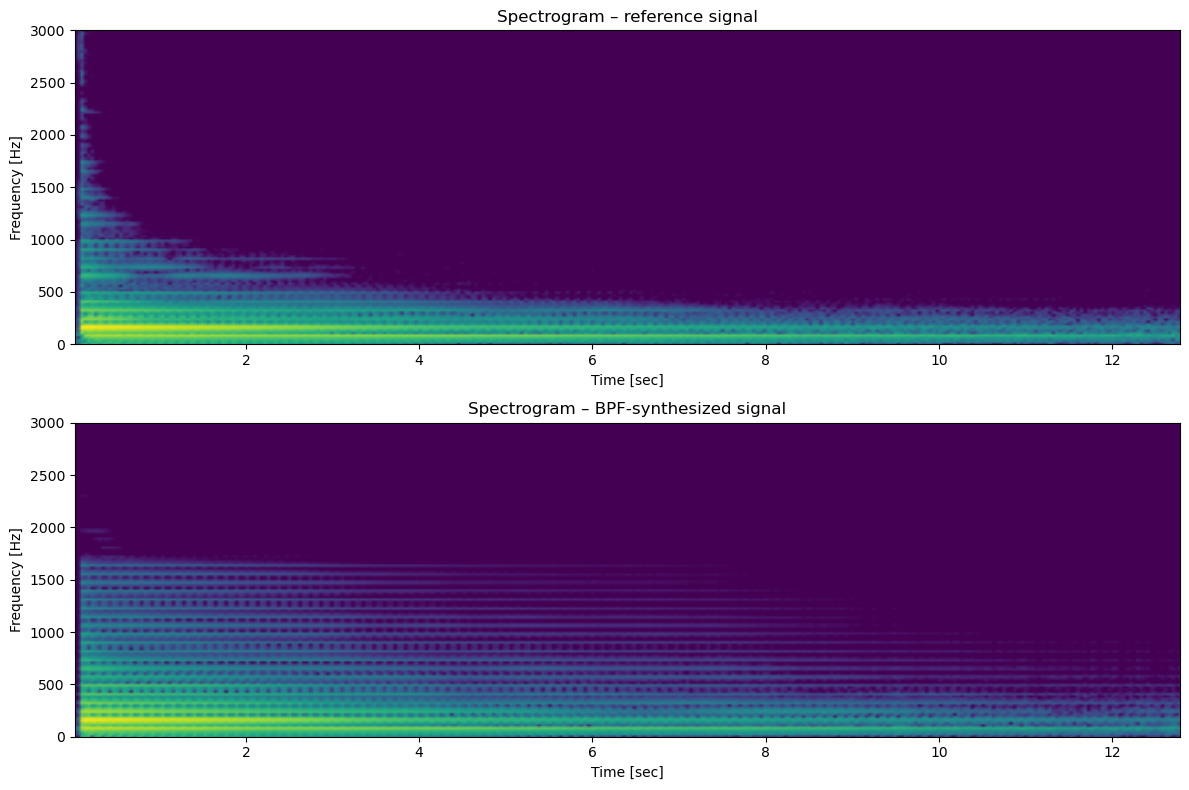

In [ ]:
n_fft = 2048   # size of the STFT window

plt.figure(figsize=(12, 8))

# Spectrogram of the reference (original) signal 
f_ref, t_ref, S_ref = signal.spectrogram(x, fs, nperseg=n_fft)
plt.subplot(2, 1, 1)
plot_spectrogram(f_ref, t_ref, S_ref)
plt.ylim(0, 3000)
plt.title("Spectrogram – reference signal")

# Spectrogram of the BPF-synthesized signal 
f_syn, t_syn, S_syn = signal.spectrogram(y_bpf, fs, nperseg=n_fft)
plt.subplot(2, 1, 2)
plot_spectrogram(f_syn, t_syn, S_syn)
plt.ylim(0, 3000)
plt.title("Spectrogram – BPF-synthesized signal")

plt.tight_layout()
plt.show()



Both spectrograms show energy at the same harmonic frequencies and similar decay patterns over time, so the synthesis with harmonic-dependent envelopes reproduces well the spectral evolution of the original note. However, the reference signal (top plot) looks “messier” and richer: the harmonics are thicker, there is more energy spread around them, and in the first seconds we see extra components due to the attack noise, slight inharmonicity and body resonances of the real recording. In contrast, the BPF-synthesized signal (bottom plot) shows very clean and thin horizontal lines for each harmonic, with almost no surrounding noise, and the decay of each harmonic is smoother and more regular. So, the synthesis with band-pass filters and envelopes reproduces well the main harmonic content and time evolution of the original sound, but it loses some of the fine details and “natural” imperfections present in the real recording, making the synthesized spectrogram look more ideal and less complex.